In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm


In [5]:
import torchvision.datasets as datasets

# Define the root directory where the dataset will be stored
root_dir = "./data"

# Download the CelebA dataset (including annotations)
celeba_dataset = datasets.CelebA(root=root_dir, split="all", download=True)

print("CelebA dataset downloaded successfully!")


Files already downloaded and verified
CelebA dataset downloaded successfully!


In [8]:
import os

data_path = "./data/celeba"
print("Dataset files:", os.listdir(data_path))



Dataset files: ['img_align_celeba.zip', 'list_attr_celeba.txt', '.DS_Store', 'list_bbox_celeba.txt', 'list_landmarks_align_celeba.txt', 'list_landmarks_celeba.txt', 'list_eval_partition.txt', 'identity_CelebA.txt', 'img_align_celeba']


In [10]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# Define transformations: Convert images to tensors
transform = transforms.Compose([
    transforms.ToTensor()  # Converts PIL Image to PyTorch Tensor
])

# Load CelebA dataset with transforms
celeba_dataset = datasets.CelebA(root="./data", split="all", download=True, transform=transform)

# Create a DataLoader
celeba_loader = DataLoader(celeba_dataset, batch_size=32, shuffle=True)

# Get a batch of images and labels
images, labels = next(iter(celeba_loader))

# Print batch shape
print("Batch shape:", images.shape)  # Should be (32, 3, 218, 178)


Files already downloaded and verified
Batch shape: torch.Size([32, 3, 218, 178])


In [15]:
from torch.utils.data import DataLoader, Subset

BATCH_SIZE = 64  # Increase batch size for better training
NUM_WORKERS = 4
DATA_DIR = "data"

# ========================
# 2. DATA LOADING (WITH STRONG AUGMENTATION)
# ========================
transform = transforms.Compose([
    #transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),  # Augmentation: Flip images randomly
    transforms.RandomRotation(10),  # Augmentation: Small rotations
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Color jittering
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = CelebA(root=DATA_DIR, split="train", transform=transform, download=True, target_type="attr")
val_dataset = CelebA(root=DATA_DIR, split="valid", transform=transform, download=True, target_type="attr")


if True: # only for debugging - train on 30% of the training set
    TRAIN_SPLIT =VAL_SPLIT = 0.25
    # Get 30% indices
    train_size = int(TRAIN_SPLIT * len(train_dataset))
    val_size = int(VAL_SPLIT * len(val_dataset))
    import numpy as np

    # Randomly sample 30% of the indices
    train_indices = np.random.choice(len(train_dataset), train_size, replace=False)
    val_indices = np.random.choice(len(val_dataset), val_size, replace=False)

    # Create subset datasets
    train_dataset = Subset(train_dataset, train_indices)
    val_dataset = Subset(val_dataset, val_indices)


    
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)


Files already downloaded and verified
Files already downloaded and verified


In [16]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# MPS device
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
print("Using device:", DEVICE)

Using device: mps


In [74]:


# ========================
# 5. TRAINING FUNCTION
# ========================
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, SAVE_MODEL_PATH= None):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(DEVICE), labels.float().to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1} Loss: {avg_loss:.4f}")
        # Validation
        validate(model, val_loader, criterion)
        evaluate(model, val_loader)
        scheduler.step()  # Update learning rate

        if SAVE_MODEL_PATH is not None:
            print(f"Saving model to {SAVE_MODEL_PATH}")
            # Save model checkpoint
            torch.save(model.state_dict(), SAVE_MODEL_PATH)

# ========================
# 6. VALIDATION FUNCTION
# ========================
def validate(model, val_loader, criterion):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.float().to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

    avg_loss = total_loss / len(val_loader)
    print(f"Validation Loss: {avg_loss:.4f}")

# ========================
# 7. EVALUATION FUNCTION
# ========================
def evaluate(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(DEVICE), labels.float().to(DEVICE)
            logits = model(images)
            probs = torch.sigmoid(logits)  # Convert logits to probabilities
            preds = (probs > 0.5).int()  # Threshold at 0.5 to get binary predictions

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    # Concatenate all predictions and labels
    preds = torch.cat(all_preds)
    true_labels = torch.cat(all_labels)

    # Compute per-class accuracy
    per_class_accuracy = (preds == true_labels).float().mean(dim=0)

    # Compute overall accuracy (average across all attributes)
    overall_accuracy = per_class_accuracy.mean().item()

    # Print results
    print(f"Overall accuracy: {overall_accuracy:.4f}")
    print(f"Per-attribute accuracy:\n{per_class_accuracy}")

    return per_class_accuracy, overall_accuracy

In [22]:

# ========================
# 1. CONFIGURATION
# ========================
#IMAGE_SIZE = 224
NUM_EPOCHS = 50  # More epochs needed
LEARNING_RATE = 0.01  # Higher initial LR when training from scratch
SAVE_MODEL_PATH = "resnet50_scratch_celeba.pth"


# ========================
# 3. MODEL DEFINITION (TRAINING FROM SCRATCH)
# ========================
model = models.resnet50(pretrained=False)  # Train from scratch
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 40)  # Modify final layer for 40 attributes
model = model.to(DEVICE)

# ========================
# 4. LOSS & OPTIMIZER
# ========================
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=1e-4)  # SGD with momentum

# Learning rate scheduler (reduce LR after plateaus)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)  # Reduce LR every 15 epochs
# ========================
# 8. TRAIN & EVALUATE MODEL
# ========================
train(model, train_loader, val_loader, criterion, optimizer, scheduler, NUM_EPOCHS, SAVE_MODEL_PATH=SAVE_MODEL_PATH)
evaluate(model, val_loader)


/Users/roy/Library/Caches/pypoetry/virtualenvs/data-to-concept-unlearning-mzp2bd5F-py3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/roy/Library/Caches/pypoetry/virtualenvs/data-to-concept-unlearning-mzp2bd5F-py3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Epoch 1/50: 100%|██████████| 636/636 [08:02<00:00,  1.32it/s]

Epoch 1 Loss: 0.4298


Validation Loss: 0.4171
Overall accuracy: 0.8162
Per-attribute accuracy:
tensor([0.8766, 0.7410, 0.6033, 0.7956, 0.9758, 0.8596, 0.8478, 0.7427, 0.7918,
        0.8504, 0.9525, 0.7543, 0.8476, 0.9362, 0.9493, 0.9287, 0.9199, 0.9523,
        0.6645, 0.5646, 0.6476, 0.5248, 0.9444, 0.9211, 0.8143, 0.7163, 0.9589,
        0.7161, 0.9279, 0.9311, 0.9237, 0.5667, 0.7946, 0.7255, 0.8155, 0.9543,
        0.6561, 0.8856, 0.9241, 0.7437])


Epoch 2/50: 100%|██████████| 636/636 [08:11<00:00,  1.29it/s]

Epoch 2 Loss: 0.4031


Validation Loss: 0.3920
Overall accuracy: 0.8285
Per-attribute accuracy:
tensor([0.8768, 0.7402, 0.6772, 0.7916, 0.9758, 0.8596, 0.8470, 0.7410, 0.7803,
        0.8886, 0.9525, 0.7543, 0.8476, 0.9362, 0.9493, 0.9287, 0.9199, 0.9523,
        0.7443, 0.6087, 0.7561, 0.5580, 0.9444, 0.9211, 0.8041, 0.7149, 0.9589,
        0.7149, 0.9279, 0.9311, 0.9237, 0.5936, 0.7946, 0.7459, 0.8155, 0.9543,
        0.7525, 0.8856, 0.9253, 0.7453])


Epoch 3/50: 100%|██████████| 636/636 [32:23<00:00,  3.06s/it]    

Epoch 3 Loss: 0.3831


Validation Loss: 0.3813
Overall accuracy: 0.8299
Per-attribute accuracy:
tensor([0.8766, 0.7322, 0.6534, 0.7954, 0.9758, 0.8596, 0.8472, 0.7350, 0.7924,
        0.8963, 0.9525, 0.7640, 0.8476, 0.9362, 0.9493, 0.9287, 0.9199, 0.9527,
        0.7600, 0.5900, 0.7884, 0.5377, 0.9444, 0.9211, 0.8139, 0.7173, 0.9589,
        0.7151, 0.9279, 0.9311, 0.9237, 0.5886, 0.7946, 0.7469, 0.8155, 0.9545,
        0.7777, 0.8856, 0.9340, 0.7541])


Epoch 4/50: 100%|██████████| 636/636 [08:47<00:00,  1.21it/s]

Epoch 4 Loss: 0.3672


Validation Loss: 0.3546
Overall accuracy: 0.8436
Per-attribute accuracy:
tensor([0.8782, 0.7362, 0.7036, 0.7906, 0.9758, 0.8596, 0.8476, 0.7495, 0.8351,
        0.9092, 0.9525, 0.7857, 0.8486, 0.9366, 0.9495, 0.9287, 0.9197, 0.9531,
        0.8019, 0.6708, 0.8486, 0.5902, 0.9444, 0.9211, 0.8292, 0.7145, 0.9587,
        0.7155, 0.9279, 0.9321, 0.9237, 0.6669, 0.7954, 0.7553, 0.8157, 0.9543,
        0.8242, 0.8856, 0.9340, 0.7751])


Epoch 5/50: 100%|██████████| 636/636 [10:10<00:00,  1.04it/s]

Epoch 5 Loss: 0.3455


Validation Loss: 0.3364
Overall accuracy: 0.8527
Per-attribute accuracy:
tensor([0.8794, 0.7497, 0.7223, 0.7886, 0.9758, 0.8596, 0.8480, 0.7678, 0.8216,
        0.9146, 0.9525, 0.7775, 0.8524, 0.9348, 0.9464, 0.9285, 0.9178, 0.9547,
        0.8270, 0.7267, 0.8834, 0.6863, 0.9436, 0.9211, 0.8407, 0.7237, 0.9587,
        0.7163, 0.9273, 0.9299, 0.9231, 0.7328, 0.7982, 0.7529, 0.8143, 0.9531,
        0.8502, 0.8844, 0.9331, 0.7888])


Epoch 6/50: 100%|██████████| 636/636 [10:00<00:00,  1.06it/s]

Epoch 6 Loss: 0.3193


Validation Loss: 0.3008
Overall accuracy: 0.8696
Per-attribute accuracy:
tensor([0.8818, 0.7580, 0.7439, 0.8008, 0.9764, 0.8600, 0.8480, 0.7779, 0.8609,
        0.9237, 0.9525, 0.8004, 0.8633, 0.9370, 0.9513, 0.9311, 0.9257, 0.9559,
        0.8681, 0.8153, 0.9263, 0.7882, 0.9442, 0.9211, 0.8683, 0.7251, 0.9603,
        0.7177, 0.9277, 0.9342, 0.9271, 0.8441, 0.7944, 0.7638, 0.8214, 0.9551,
        0.8921, 0.8856, 0.9464, 0.8075])


Epoch 7/50: 100%|██████████| 636/636 [09:19<00:00,  1.14it/s]

Epoch 7 Loss: 0.2997


Validation Loss: 0.2875
Overall accuracy: 0.8739
Per-attribute accuracy:
tensor([0.8876, 0.7704, 0.7366, 0.7696, 0.9768, 0.8899, 0.8480, 0.7690, 0.8754,
        0.9317, 0.9525, 0.8071, 0.8641, 0.9356, 0.9513, 0.9368, 0.9325, 0.9619,
        0.8820, 0.8258, 0.9388, 0.8035, 0.9422, 0.9211, 0.8852, 0.7324, 0.9591,
        0.7163, 0.9283, 0.9321, 0.9386, 0.8629, 0.7974, 0.7674, 0.8270, 0.9573,
        0.9003, 0.8856, 0.9458, 0.8097])


Epoch 8/50: 100%|██████████| 636/636 [09:30<00:00,  1.12it/s]

Epoch 8 Loss: 0.2858


Validation Loss: 0.2765
Overall accuracy: 0.8794
Per-attribute accuracy:
tensor([0.8921, 0.7741, 0.7743, 0.8035, 0.9764, 0.9144, 0.8290, 0.7753, 0.8743,
        0.9299, 0.9525, 0.8029, 0.8713, 0.9372, 0.9499, 0.9509, 0.9402, 0.9605,
        0.8832, 0.8397, 0.9458, 0.8194, 0.9448, 0.9211, 0.9048, 0.7328, 0.9605,
        0.7237, 0.9323, 0.9333, 0.9412, 0.8741, 0.7962, 0.7600, 0.8266, 0.9619,
        0.9056, 0.8860, 0.9476, 0.8252])


Epoch 9/50: 100%|██████████| 636/636 [13:52<00:00,  1.31s/it]

Epoch 9 Loss: 0.2750


Validation Loss: 0.2679
Overall accuracy: 0.8837
Per-attribute accuracy:
tensor([0.8973, 0.7787, 0.7763, 0.8081, 0.9768, 0.9279, 0.8484, 0.7819, 0.8721,
        0.9335, 0.9525, 0.8176, 0.8794, 0.9382, 0.9525, 0.9563, 0.9426, 0.9623,
        0.8911, 0.8260, 0.9404, 0.8395, 0.9430, 0.9211, 0.9152, 0.7338, 0.9607,
        0.7211, 0.9317, 0.9358, 0.9438, 0.8824, 0.8008, 0.7898, 0.8256, 0.9640,
        0.9092, 0.8862, 0.9511, 0.8321])


Epoch 10/50: 100%|██████████| 636/636 [07:57<00:00,  1.33it/s]

Epoch 10 Loss: 0.2661


Validation Loss: 0.2640
Overall accuracy: 0.8852
Per-attribute accuracy:
tensor([0.9015, 0.7841, 0.7374, 0.8071, 0.9756, 0.9317, 0.8510, 0.7884, 0.8727,
        0.9335, 0.9527, 0.7956, 0.8868, 0.9394, 0.9527, 0.9690, 0.9442, 0.9642,
        0.8806, 0.8453, 0.9555, 0.8637, 0.9472, 0.9211, 0.9219, 0.7261, 0.9605,
        0.7235, 0.9333, 0.9368, 0.9418, 0.8927, 0.8000, 0.7839, 0.8337, 0.9694,
        0.9116, 0.8854, 0.9511, 0.8335])


Epoch 11/50: 100%|██████████| 636/636 [08:04<00:00,  1.31it/s]

Epoch 11 Loss: 0.2585


Validation Loss: 0.2643
Overall accuracy: 0.8854
Per-attribute accuracy:
tensor([0.9041, 0.7896, 0.7704, 0.8053, 0.9766, 0.9265, 0.8377, 0.7708, 0.8647,
        0.9317, 0.9525, 0.8041, 0.8848, 0.9378, 0.9513, 0.9718, 0.9450, 0.9654,
        0.8836, 0.8500, 0.9484, 0.8963, 0.9462, 0.9211, 0.9176, 0.7366, 0.9601,
        0.7280, 0.9335, 0.9372, 0.9358, 0.8963, 0.7980, 0.7716, 0.8323, 0.9716,
        0.9098, 0.8860, 0.9474, 0.8198])


Epoch 12/50:   5%|▌         | 34/636 [00:34<10:10,  1.01s/it] 


KeyboardInterrupt: 

In [ ]:
labels[0]
# Extract targets manually
subset_targets = []
for i in range(len(train_dataset)):
    if i % 10_000 == 0:
        print("Processing sample", i)
    subset_targets.append(train_dataset[i][1])

subset_targets = torch.stack(subset_targets)

['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young', '']


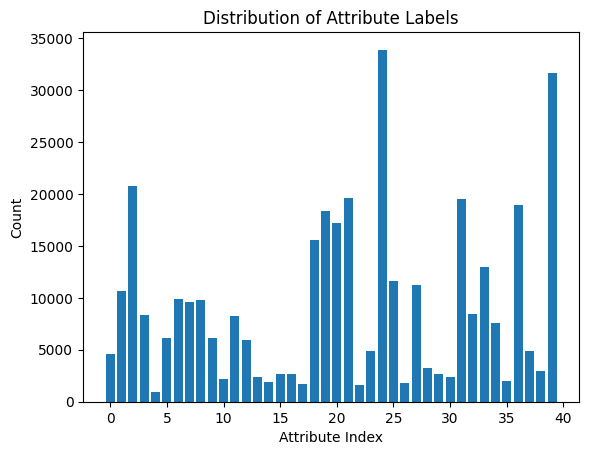

In [45]:
# 1 identify labels of attributes
#attribute_labels = 
print(train_dataset.dataset.attr_names)
# print histogram of labels
import matplotlib.pyplot as plt

import numpy as np

counts = np.sum(subset_targets.numpy(), axis=0)
counts
# plot bar chart of counts
plt.bar(range(len(counts)), counts)
plt.xlabel("Attribute Index")
plt.ylabel("Count")
plt.title("Distribution of Attribute Labels")
plt.show()

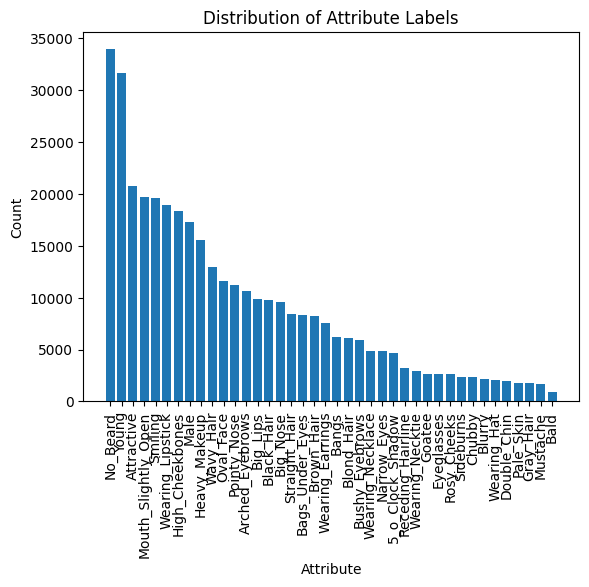

In [67]:
attribute_to_count = {train_dataset.dataset.attr_names[i] : counts[i] for i in range(len(counts))}
# Sort attributes by count
sorted_attributes = sorted(attribute_to_count.items(), key=lambda x: x[1], reverse=True)
# Print sorted attributes
#for attr, count in sorted_attributes:
#    print(f"{attr}: \t\t {count}")
# plot sorted attributes with counts, with text annotainos
x_axis = [attr for attr, count in sorted_attributes]
y_axis = [count for attr, count in sorted_attributes]
plt.bar(x_axis, y_axis)
plt.xlabel("Attribute")
plt.ylabel("Count")
plt.title("Distribution of Attribute Labels")
plt.xticks(rotation=90)
plt.show()

In [49]:
subset_targets_np = subset_targets.numpy()

correlation_matrix = np.corrcoef(subset_targets_np, rowvar=False)
correlation_matrix.shape

(40, 40)

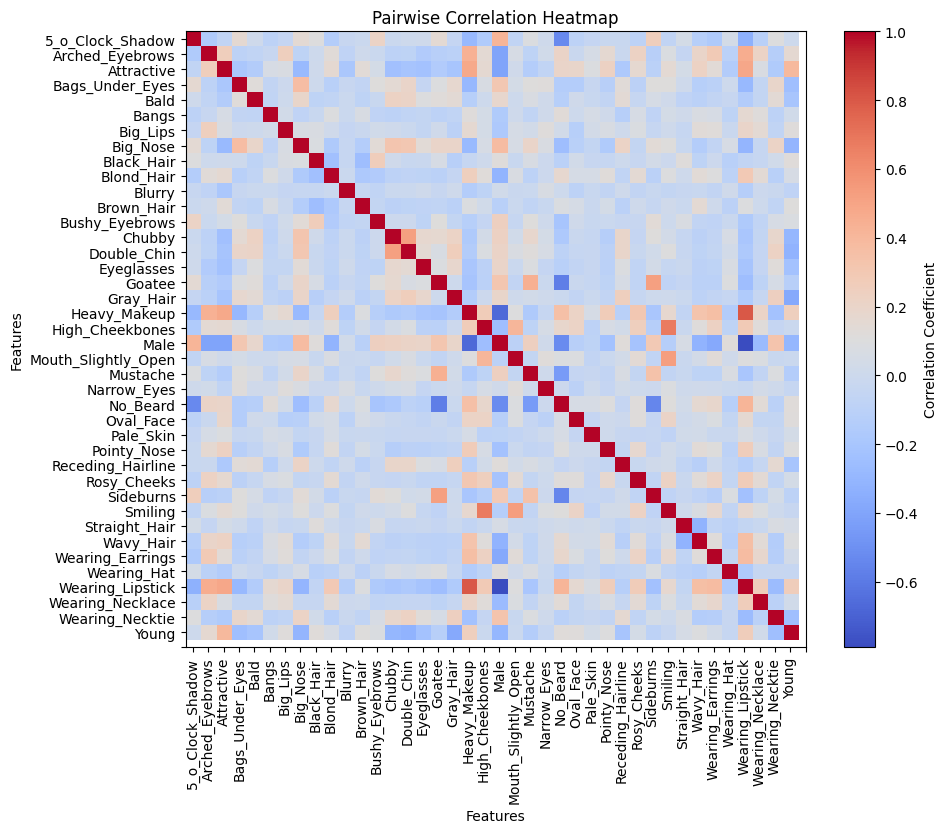

In [59]:
import matplotlib.pyplot as plt
attr_names = train_dataset.dataset.attr_names

plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap="coolwarm", aspect="auto")
plt.colorbar(label="Correlation Coefficient")

# Set x and y ticks
plt.xticks(ticks=range(len(attr_names)), labels=attr_names, rotation=90)
plt.yticks(ticks=range(len(attr_names)), labels=attr_names)

plt.title("Pairwise Correlation Heatmap")
plt.xlabel("Features")
plt.ylabel("Features")
plt.show()


In [62]:
average_correlation = np.mean(correlation_matrix, axis=1)
attribute_to_correlation = {train_dataset.dataset.attr_names[i] : correlation_matrix[i] for i in range(len(correlation_matrix))}
# Sort attributes by average correlation
sorted_attributes = sorted(attribute_to_correlation.items(), key=lambda x: np.mean(x[1]), reverse=True)
# Print sorted attributes
for attr, correlation in sorted_attributes:
    print(f"{attr}: \t\t {np.mean(correlation):.4f}")

Smiling: 		 0.0923
High_Cheekbones: 		 0.0878
Mouth_Slightly_Open: 		 0.0687
Rosy_Cheeks: 		 0.0653
Heavy_Makeup: 		 0.0617
Arched_Eyebrows: 		 0.0594
Wearing_Lipstick: 		 0.0562
Wearing_Earrings: 		 0.0553
Big_Lips: 		 0.0549
Double_Chin: 		 0.0530
Big_Nose: 		 0.0527
Chubby: 		 0.0494
Wearing_Necklace: 		 0.0476
Attractive: 		 0.0429
Narrow_Eyes: 		 0.0390
Pointy_Nose: 		 0.0358
Wavy_Hair: 		 0.0354
Oval_Face: 		 0.0351
Bags_Under_Eyes: 		 0.0343
Mustache: 		 0.0335
Receding_Hairline: 		 0.0334
Bushy_Eyebrows: 		 0.0309
Bald: 		 0.0297
Wearing_Necktie: 		 0.0280
Goatee: 		 0.0262
Blond_Hair: 		 0.0254
Gray_Hair: 		 0.0248
Sideburns: 		 0.0221
Bangs: 		 0.0203
Black_Hair: 		 0.0193
Pale_Skin: 		 0.0156
Straight_Hair: 		 0.0097
Eyeglasses: 		 0.0068
Brown_Hair: 		 0.0028
5_o_Clock_Shadow: 		 0.0017
Young: 		 -0.0006
No_Beard: 		 -0.0035
Wearing_Hat: 		 -0.0070
Blurry: 		 -0.0099
Male: 		 -0.0241


In [76]:
attribute_ = "Bags_Under_Eyes"
attr_index = train_dataset.dataset.attr_names.index(attribute_)
attr_index

indices_without_attr = np.where(subset_targets_np[:, attr_index] == 0)[0]
print("Number of samples without attribute:", len(indices_without_attr))

dataset_without_attribute = Subset(train_dataset, indices_without_attr)
len(dataset_without_attribute)
# train on dataset without attribute

train_loader_without_attr = DataLoader(dataset_without_attribute, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)



Number of samples without attribute: 32345


In [77]:
#


# ========================
# 1. CONFIGURATION
# ========================
#IMAGE_SIZE = 224
NUM_EPOCHS = 50  # More epochs needed
LEARNING_RATE = 0.01  # Higher initial LR when training from scratch
SAVE_MODEL_PATH = f"resnet50_scratch_celeba__remove_{attribute_}.pth"


# ========================
# 3. MODEL DEFINITION (TRAINING FROM SCRATCH)
# ========================
model_without_attr = models.resnet50(pretrained=False)  # Train from scratch
num_ftrs = model_without_attr.fc.in_features
model_without_attr.fc = nn.Linear(num_ftrs, 40)  # Modify final layer for 40 attributes
model_without_attr = model_without_attr.to(DEVICE)

# ========================
# 4. LOSS & OPTIMIZER
# ========================
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model_without_attr.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=1e-4)  # SGD with momentum

# Learning rate scheduler (reduce LR after plateaus)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)  # Reduce LR every 15 epochs
# ========================
# 8. TRAIN & EVALUATE MODEL
# ========================
train(model_without_attr, train_loader_without_attr, val_loader, criterion, optimizer, scheduler, NUM_EPOCHS, SAVE_MODEL_PATH=SAVE_MODEL_PATH)
evaluate(model_without_attr, val_loader)

Epoch 1/50: 100%|██████████| 506/506 [06:21<00:00,  1.33it/s]

Epoch 1 Loss: 0.4056


Validation Loss: 0.4591
Overall accuracy: 0.8121
Per-attribute accuracy:
tensor([0.8766, 0.7414, 0.5699, 0.7956, 0.9758, 0.8596, 0.8478, 0.7427, 0.7914,
        0.8502, 0.9525, 0.7543, 0.8476, 0.9362, 0.9493, 0.9285, 0.9199, 0.9523,
        0.6305, 0.5606, 0.6053, 0.5332, 0.9444, 0.9211, 0.8149, 0.7173, 0.9589,
        0.7161, 0.9279, 0.9311, 0.9237, 0.5528, 0.7946, 0.7255, 0.8155, 0.9541,
        0.6126, 0.8856, 0.9241, 0.7437])


Epoch 2/50:   9%|▉         | 47/506 [00:43<07:02,  1.09it/s] 


KeyboardInterrupt: 